# Designing a Spam Filter

__Author:__ Maximilian Eckstein \
__Date:__ 2025-06-20

This project implements a binary spam classifier using emails from the Apache SpamAssassin Public Corpus. The workflow includes:

- Downloading and parsing labeled emails (ham/spam)
- Structuring the data and splitting into train/test sets
- Preprocessing email text using a custom pipeline (binary vectorization, optional stemming/header)
- Training and evaluating multiple classifiers

Best results were achieved using **Logistic Regression** and **Linear SVC** with binary vectorization.

### Tools and References:
- The implementation follows the structure and methodology outlined in the **MLDS course slides**.
- Development and model evaluation were supported with **OpenAI ChatGPT-4o**.
- Code is written in Python and follows **PEP 8** formatting standards.

### Libraries used:
- `pandas`, `email`, `re`
- `scikit-learn`: preprocessing, model selection, classification, metrics
- `matplotlib` for visualization
- `Pathlib` for file handling

## Dataset Preparation and Email Format

The dataset consists of multiple folders containing plaintext email files. Each email includes a full MIME header and body.

**Downloaded folders:**
- `easy_ham`
- `easy_ham_2`
- `hard_ham`
- `spam`
- `spam_2`

**Email parsing steps:**
- Extract header fields: `From`, `Subject`, `Date`
- Extract and normalize the body content
- Identify common structure patterns for automation

One representative file is printed and dissected to verify format.


## Example Email Dissection

To understand the structure of the dataset, a sample email is manually parsed. This reveals the typical layout used across files.

Key components extracted:
- Sender
- Subject
- Date
- Body content (first 500 characters preview)

This insight forms the basis for automated parsing and label assignment in the following step.

In [49]:
from pathlib import Path
import email
import pandas as pd

# Load and inspect a single example email from the dataset
sample_path = Path("../data/raw/easy_ham/00001.7c53336b37003a9286aba55d2945844c")

with open(sample_path, encoding="latin-1") as file:
    message = email.message_from_file(file)

# Print email header information
print("\n--------------- HEADER ---------------\n")
print("From:", message.get("From"))
print("Subject:", message.get("Subject"))
print("Date:", message.get("Date"))

# Extract email body (handle multipart messages)
payload = message.get_payload()
if isinstance(payload, list):
    payload = ''.join([str(part.get_payload()) for part in payload])
else:
    payload = str(payload)

# Preview the body (first 500 characters)
print("\n--- BODY (Preview: 500 characters) ---\n")
print(payload[:500])


--------------- HEADER ---------------

From: Robert Elz <kre@munnari.OZ.AU>
Subject: Re: New Sequences Window
Date: Thu, 22 Aug 2002 18:26:25 +0700

--- BODY (Preview: 500 characters) ---

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrac


## Dataset Construction

All available emails are parsed and stored in a single DataFrame. Each entry contains:

- `from` – email sender
- `subject` – subject line
- `body` – email body content
- `label` – 0 for ham, 1 for spam

The parser handles multipart emails and encodes them as strings. Labels are assigned based on the containing folder (e.g., `spam/` → 1).

This structured format serves as input for further preprocessing and classification.

In [50]:
from email.message import Message

def parse_email(msg: Message) -> dict:
    """
    Extracts header and body content from an email message.

    Parameters:
        msg (email.message.Message): A parsed email object.

    Returns:
        dict: A dictionary containing the sender, subject, and body.
    """
    from_ = msg.get("From", "")
    subject = msg.get("Subject", "")
    payload = msg.get_payload()
    
    if isinstance(payload, list):
        payload = ''.join([str(part.get_payload()) for part in payload])
    else:
        payload = str(payload)

    return {
        "from": from_,
        "subject": subject,
        "body": payload
    }

def load_emails_from_dir(directory: Path, label: int) -> list[dict]:
    """
    Loads all emails in a directory and assigns them a label.

    Parameters:
        directory (Path): Path to the directory containing email files.
        label (int): 1 for spam, 0 for ham.

    Returns:
        list of dict: Parsed emails with labels.
    """
    emails = []

    for file_path in directory.iterdir():
        if file_path.is_file():
            with open(file_path, encoding="latin-1") as f:
                msg = email.message_from_file(f)
                parsed = parse_email(msg)
                parsed["label"] = label
                emails.append(parsed)

    return emails

def load_data() -> pd.DataFrame:
    """
    Loads the full dataset from the raw directory structure and
    returns a DataFrame with all emails and their labels.

    Returns:
        pd.DataFrame: DataFrame with 'from', 'subject', 'body', 'label'.
    """
    base_path = Path("../data/raw")
    data = []

    # Add all labeled datasets
    data += load_emails_from_dir(base_path / "easy_ham", 0)
    data += load_emails_from_dir(base_path / "easy_ham_2", 0)
    data += load_emails_from_dir(base_path / "hard_ham", 0)
    data += load_emails_from_dir(base_path / "spam", 1)
    data += load_emails_from_dir(base_path / "spam_2", 1)

    return pd.DataFrame(data, columns=["from", "subject", "body", "label"])


# Load all emails into a DataFrame
df = load_data()

# Quick overview
print(df.info())
print(df["label"].value_counts())

# Show first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051 entries, 0 to 6050
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   from     6051 non-null   object
 1   subject  6051 non-null   object
 2   body     6051 non-null   object
 3   label    6051 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 189.2+ KB
None
label
0    4153
1    1898
Name: count, dtype: int64


,from,subject,body,label
0,Robert Elz <kre@munnari.OZ.AU>,Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,Steve Burt <Steve_Burt@cursor-system.com>,[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,"""Tim Chapman"" <timc@2ubh.com>",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Monty Solomon <monty@roscom.com>,[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0


## Split Data into Train and Test Sets

The dataset is split using a **90% / 10% ratio**, maintaining label distribution with stratification.

- **Training set**: used for fitting and tuning classifiers
- **Test set**: used for final evaluation of generalization

Both sets are analyzed to ensure that class balance is preserved:

- Total counts
- Spam ratio in train/test

In [51]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df[["from", "subject", "body"]]  # Potential input features
y = df["label"]                      # Target label: 0 = ham, 1 = spam

# Perform stratified train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)


# Confirm distributions
print(f"Training set: {len(X_train_raw)} emails")
print(f"Test set: {len(X_test_raw)} emails\n")
print("Label distribution in training set:\n", y_train.value_counts())
print(f"\nPercantage of spam in training set: {(y_train.mean() * 100):.2f} %\n")
print("Label distribution in test set:\n", y_test.value_counts())
print(f"\nPercantage of spam in test set: {(y_test.mean() * 100):.2f} %\n")

Training set: 5445 emails
Test set: 606 emails

Label distribution in training set:
 label
0    3737
1    1708
Name: count, dtype: int64

Percantage of spam in training set: 31.37 %

Label distribution in test set:
 label
0    416
1    190
Name: count, dtype: int64

Percantage of spam in test set: 31.35 %



## Data Preprocessing Pipeline

We implemented a flexible `DataPipeline` class for cleaning and vectorizing email text.

### Key steps:
- **Text cleaning**: Replace URLs, numbers; remove punctuation and HTML tags
- **Case normalization**: Convert all text to lowercase
- **Stemming** (optional): Reduces word forms via suffix stripping
- **Header inclusion** (optional): Adds `from` and `subject` to feature text
- **Vectorization**:
  - Binary → word presence
  - Count → word frequency
- **Stopword removal**: If binary mode is enabled
- **Vocabulary filtering**: `min_df=2`, `max_df=0.95`

**Note:** Due to superior performance and assignment constraints, only **binary vectorization** was used in the final evaluation.

In [52]:
import re
from sklearn.feature_extraction.text import CountVectorizer


class SimpleStemmer:
    """
    A basic rule-based stemmer that removes common English suffixes.
    """
    def stem(self, word: str) -> str:
        for suffix in ["ing", "ly", "ed", "ious", "ies", "ive", "es", "s", "ment"]:
            if word.endswith(suffix) and len(word) > len(suffix):
                return word[:-len(suffix)]
        return word


class DataPipeline:
    """
    Custom text preprocessing and vectorization pipeline.

    Parameters:
        use_header (bool): If True, include email headers ("from" and "subject") in the text.
        binary (bool): If True, use binary vectorization (presence/absence). If False, use term frequencies.
        use_stemming (bool): If True, apply a basic stemmer to reduce word forms.

    Methods:
        fit_transform(df): Fit the vectorizer and return the feature matrix for training data.
        transform(df): Transform new data using the fitted vectorizer.
    """

    def __init__(self, use_header=True, binary=True, use_stemming=False):
        self.use_header = use_header
        self.binary = binary
        self.use_stemming = use_stemming
        self.vectorizer = None
        self.stemmer = SimpleStemmer() if use_stemming else None

    def _clean_text(self, text: str) -> str:
        """
        Basic text normalization: remove punctuation, lowercase, replace URLs and numbers.
        """
        text = re.sub(r"http\S+|www\S+|https\S+", "URL", text)
        text = re.sub(r"\b\d+\b", "NUMBER", text)
        text = re.sub(r"[^\w\s]", " ", text)
        text = re.sub(r"<.*?>", " ", text)         
        text = re.sub(r"[\r\n\t]", " ", text)
        return text.lower()

    def _tokenize_and_stem(self, text: str) -> list[str]:
        """
        Tokenize and optionally stem the text.
        """
        tokens = self._clean_text(text).split()
        return [self.stemmer.stem(token) for token in tokens]

    def _build_text(self, df) -> list[str]:
        """
        Construct the full text content from selected columns.
        """
        if self.use_header:
            return (
                df["from"].fillna("") + " " +
                df["subject"].fillna("") + " " +
                df["body"].fillna("")
            ).values
        else:
            return df["body"].fillna("").values

    def fit_transform(self, df):
        """
        Fit the vectorizer on the input data and return the feature matrix.

        Returns:
            scipy.sparse matrix: Vectorized training features.
        """
        texts = self._build_text(df)

        if self.use_stemming:
            self.vectorizer = CountVectorizer(
                tokenizer=self._tokenize_and_stem,
                lowercase=False,    # Already handled in _clean_text
                binary=self.binary,
                stop_words='english' if self.binary else None,
                min_df=2,
                max_df=0.95
            )
        else:
            self.vectorizer = CountVectorizer(
                preprocessor=self._clean_text,
                lowercase=False,    # Already handled in _clean_text
                binary=self.binary,
                stop_words='english' if self.binary else None,
                min_df=2,
                max_df=0.95
            )

        return self.vectorizer.fit_transform(texts)

    def transform(self, df):
        """
        Transform new data using the already fitted vectorizer.

        Returns:
            scipy.sparse matrix: Vectorized test features.
        """
        texts = self._build_text(df)
        return self.vectorizer.transform(texts)


# Create different variants of the data pipeline

# Variant 1: binary vectors, use header, with stemming
pipeline_bhs = DataPipeline(use_header=True, binary=True, use_stemming=True)
X_train_bhs = pipeline_bhs.fit_transform(X_train_raw)
X_test_bhs = pipeline_bhs.transform(X_test_raw)

# Variant 2: binary vectors, use header, without stemming
pipeline_bhn = DataPipeline(use_header=True, binary=True, use_stemming=False)
X_train_bhn = pipeline_bhn.fit_transform(X_train_raw)
X_test_bhn = pipeline_bhn.transform(X_test_raw)

# Variant 3: count vectors, no header, with stemming
pipeline_cns = DataPipeline(use_header=False, binary=False, use_stemming=True)
X_train_cns = pipeline_cns.fit_transform(X_train_raw)
X_test_cns = pipeline_cns.transform(X_test_raw)

# Variant 4: count vectors, no header, without stemming
pipeline_cnn = DataPipeline(use_header=False, binary=False, use_stemming=False)
X_train_cnn = pipeline_cnn.fit_transform(X_train_raw)
X_test_cnn = pipeline_cnn.transform(X_test_raw)


print("Variante 1 (binary, header, stemming):", X_train_bhs.shape)
print("Variante 2 (binary, header, no stemming):", X_train_bhn.shape)
print("Variante 3 (count, no header, stemming):", X_train_cns.shape)
print("Variante 4 (count, no header, no stemming):", X_train_cnn.shape)

c:\Users\maxec\Documents\Studium\4. Semester\Machine Learning and Data Science I\Assignments\MLDS1-Assignment_B\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\maxec\Documents\Studium\4. Semester\Machine Learning and Data Science I\Assignments\MLDS1-Assignment_B\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acros', 'afterward', 'alway', 'anyth', 'becom', 'besid', 'dur', 'everyth', 'f', 'g', 'ha', 'hi', 'hundr', 'inde', 'les', 'nevertheles', 'noth', 'ourselv', 'perhap', 'ser', 'someth', 'sometim', 'themselv', 'thi', 'thu', 'u', 'wa', 'wherea', 'yourselv'] not in stop_words.
  warnings.warn(


Variante 1 (binary, header, stemming): (5445, 28824)
Variante 2 (binary, header, no stemming): (5445, 33733)
Variante 3 (count, no header, stemming): (5445, 28236)
Variante 4 (count, no header, no stemming): (5445, 33105)


## Train and Compare Multiple Classifiers

Five models were trained on each pipeline variant to evaluate their spam detection capabilities:

- `DummyClassifier`: Baseline model (always predicts the majority class)
- `Multinomial Naive Bayes`
- `Logistic Regression`
- `Linear Support Vector Classifier (LinearSVC)`
- `Random Forest`

### Evaluation Metrics:
- **Precision**: What portion of predicted spams are actually spam?
- **Recall**: What portion of actual spams are caught?
- **F1 Score**: Harmonic mean of precision and recall

The DummyClassifier serves as a baseline:
> The DummyClassifier with `most_frequent` strategy always predicts the majority class (ham). As a result, it never predicts spam, leading to a precision, recall and F1-score of 0 for the positive class. This highlights the need for a model that effectively detects spam.

Results show that **binary vectorization**, without stemming, produced the best results. The top models were **Logistic Regression** and **Linear SVC**.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Define classifiers to evaluate
classifiers = {
    "Dummy (Most Frequent)": DummyClassifier(strategy="most_frequent", random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, C=1, penalty="l2", solver="liblinear", random_state=42),
    "Linear SVC": LinearSVC(max_iter=10000, C=0.1, penalty="l2", loss="squared_hinge", dual=False, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
}

# Prepare the four data variants (generated earlier with DataPipeline)
variant_names = [
    "Binary + Header + Stemming",
    "Binary + Header (No Stemming)",
    "Count Only Body + Stemming",
    "Count Only Body (No Stemming)"
]

X_train_variants = [X_train_bhs, X_train_bhn]
X_test_variants = [X_test_bhs, X_test_bhn]

# dictonarys for precision, recall, and f1 scores
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Evaluation loop: Test all classifiers on all variants
for variant_name, X_train, X_test in zip(variant_names, X_train_variants, X_test_variants):
    print(f"\n{'='*76}")
    print(f"Variant: {variant_name}")
    print(f"{'='*76}")

    precision_scores[variant_name] = {}
    recall_scores[variant_name] = {}
    f1_scores[variant_name] = {}


    for clf_name, clf in classifiers.items():
        model = Pipeline([
            ('vectorizer', 'passthrough'),
            ('classifier', clf)
        ])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Store and print precision, recall, and F1 scores
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        precision_scores[variant_name][clf_name] = precision

        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall_scores[variant_name][clf_name] = recall
        
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        f1_scores[variant_name][clf_name] = f1

        print(f"{clf_name:25s} → Precision: {precision:.2f} → Recall: {recall:.2f} → F1 Score: {f1:.2f}")

        # Save models for later detailed evaluation
        if clf_name in ["Logistic Regression", "Linear SVC"] and variant_name == "Binary + Header (No Stemming)":
            if clf_name == "Logistic Regression":
                final_log_model = model
            elif clf_name == "Linear SVC":
                final_svc_model = model



Variant: Binary + Header + Stemming
Dummy (Most Frequent)     → Precision: 0.00 → Recall: 0.00 → F1 Score: 0.00
Naive Bayes               → Precision: 0.96 → Recall: 0.96 → F1 Score: 0.96
Logistic Regression       → Precision: 0.97 → Recall: 0.99 → F1 Score: 0.98
Linear SVC                → Precision: 0.97 → Recall: 0.98 → F1 Score: 0.98
Random Forest             → Precision: 0.96 → Recall: 0.96 → F1 Score: 0.96

Variant: Binary + Header (No Stemming)
Dummy (Most Frequent)     → Precision: 0.00 → Recall: 0.00 → F1 Score: 0.00
Naive Bayes               → Precision: 0.96 → Recall: 0.96 → F1 Score: 0.96
Logistic Regression       → Precision: 0.97 → Recall: 0.99 → F1 Score: 0.98
Linear SVC                → Precision: 0.97 → Recall: 0.99 → F1 Score: 0.98
Random Forest             → Precision: 0.97 → Recall: 0.95 → F1 Score: 0.96


## Final Evaluation of Best Models

The two best models were selected for a detailed performance analysis:

- **Logistic Regression**
- **Linear SVC**

Both were trained on the **"Binary + Header (No Stemming)"** variant.

### For each model, we visualize:
- **Confusion Matrix**: TP / TN / FP / FN
- **ROC Curve**: Visualizes classifier trade-offs
- **AUC Score**: Area under the ROC curve
- **Full classification report**: Precision, Recall, F1 per class

This final comparison confirms the practical effectiveness of both models in detecting spam emails with high accuracy and minimal false positives.


Logistic Regression


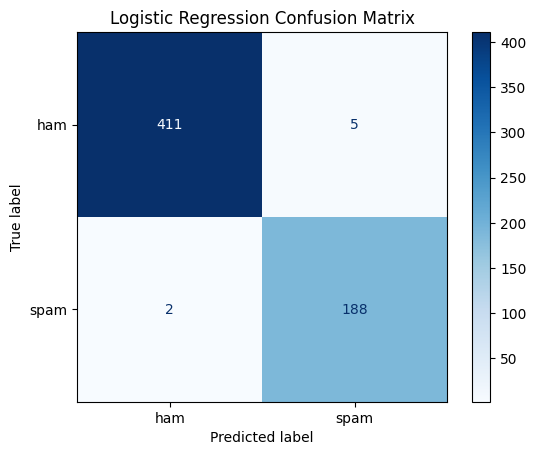

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       416
        spam       0.97      0.99      0.98       190

    accuracy                           0.99       606
   macro avg       0.98      0.99      0.99       606
weighted avg       0.99      0.99      0.99       606



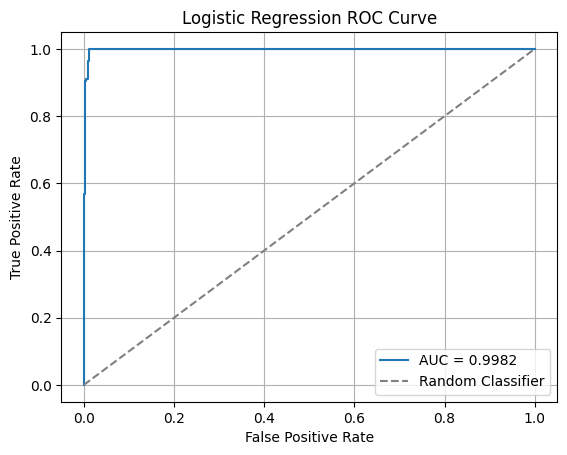


Linear SVC


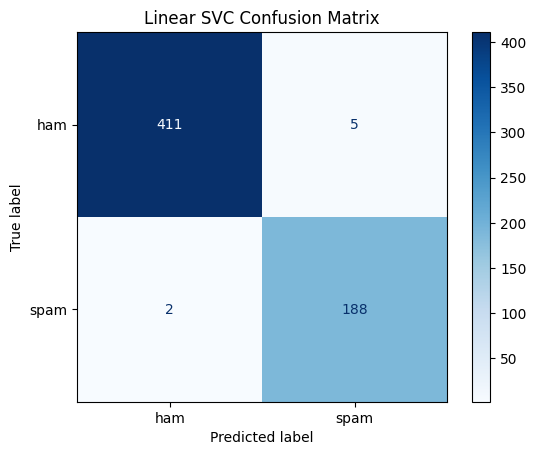

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       416
        spam       0.97      0.99      0.98       190

    accuracy                           0.99       606
   macro avg       0.98      0.99      0.99       606
weighted avg       0.99      0.99      0.99       606



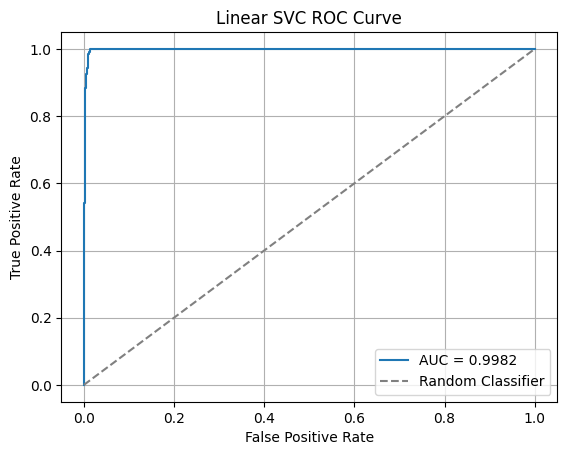

In [54]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": final_log_model,
    "Linear SVC": final_svc_model
}

for name, model in models.items():
    print(f"\n{'='*60}\n{name}\n{'='*60}")
    
    y_pred = model.predict(X_test_bhn)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Classification Report
    print(classification_report(y_test, y_pred, target_names=["ham", "spam"], zero_division=0))

    # ROC & AUC
    if hasattr(model.named_steps["classifier"], "predict_proba"):
        y_scores = model.named_steps["classifier"].predict_proba(X_test_bhn)[:, 1]
    else:
        y_scores = model.named_steps["classifier"].decision_function(X_test_bhn)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()